In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# from tqdm.notebook import tqdm
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split,StratifiedKFold
from skimage.util import view_as_windows,view_as_blocks
from sklearn.cluster import KMeans


%matplotlib inline

In [2]:
train = pd.read_csv("./train.csv")

In [3]:
train.shape

(1821, 5)

In [4]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [5]:
images = train['image_id'].copy()
image_path = [f"./images/{i}.jpg" for i in images.values.tolist()]
ratio = 0.25
reshape = (int(2048 * ratio),int(1365 * ratio))
shape = (1,int(1365 * ratio),int(2048 * ratio),3)

code = cv2.COLOR_BGR2RGB

images = cv2.cvtColor(cv2.resize(cv2.imread(image_path.pop(0)),reshape[:2]),code).reshape(shape)

for i in tqdm(image_path):
    image = cv2.cvtColor(cv2.resize(cv2.imread(i),reshape[:2]),code).reshape(shape)
    images = np.concatenate([images,image],axis=0)

np.save("./train.npy",images)

In [6]:
images = np.load("./train.npy")

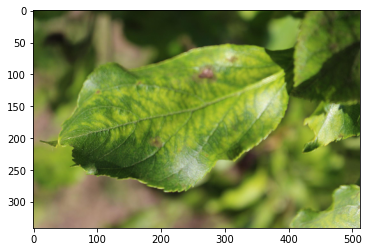

In [7]:
plt.imshow(images[0])

In [8]:
labels = train.copy()
labels.pop("image_id");
labels = labels.values

In [9]:
classes = ['healthy','multiple_diseases','rust','scab']

In [10]:
def intersection(ai, bi):
    x = max(ai[0], bi[0])
    y = max(ai[1], bi[1])
    w = min(ai[2], bi[2]) - x
    h = min(ai[3], bi[3]) - y
    if w < 0 or h < 0:
        return 0
    return w*h


def suppress(boxes):
    bxs = pd.DataFrame(boxes).sort_values(by=[0,1,2,3]).values.tolist()
    ax = True
    j = 0
    c = 30
    while j < 16:
        i = 0
        c = 0
        while i < len(bxs)-1:
            if intersection(bxs[i],bxs[i+1]) > 0:
                a,b = bxs.pop(i),bxs.pop(i)
                bxs.insert(i,[min(a[0],b[0]),min(a[1],b[1]),max(a[2],b[2]),max(a[3],b[3])])
                c += 1
                continue
            i += 1
        bxs = pd.DataFrame(bxs).sort_values(by=[j%4]).values.tolist()
        ax = not ax
        j += 1
    return bxs


def get_boxes(img):
    alpha = (img[:,:,0] < img[:,:,1]).astype(np.uint8)
    mask = cv2.dilate(alpha,np.array([
        [1,1,1,1],
        [1,1,1,1],
        [1,1,1,1],
        [1,1,1,1],
    ])*10)
    w = 5
    window = view_as_windows(mask,w)
    mask = window.reshape(*window.shape[:2],w*w).mean(axis=2).astype(np.uint8)
    w = 3
    window = view_as_windows(mask,w)
    mask = window.reshape(*window.shape[:2],w*w).std(axis=2)
    mask = (mask > 0.1).astype(np.uint8)
    cnt,h = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    cnt = [i.reshape(-1,2) for i in cnt]
    boxes = [[i[:,0].min()-2,i[:,1].min()-2,i[:,0].max()+4,i[:,1].max()+4] for i in cnt]
    boxes = [[xmin,ymin,xmax,ymax] for xmin,ymin,xmax,ymax in boxes if (xmax - xmin) * (ymax - ymin) < 5000]    
    return boxes

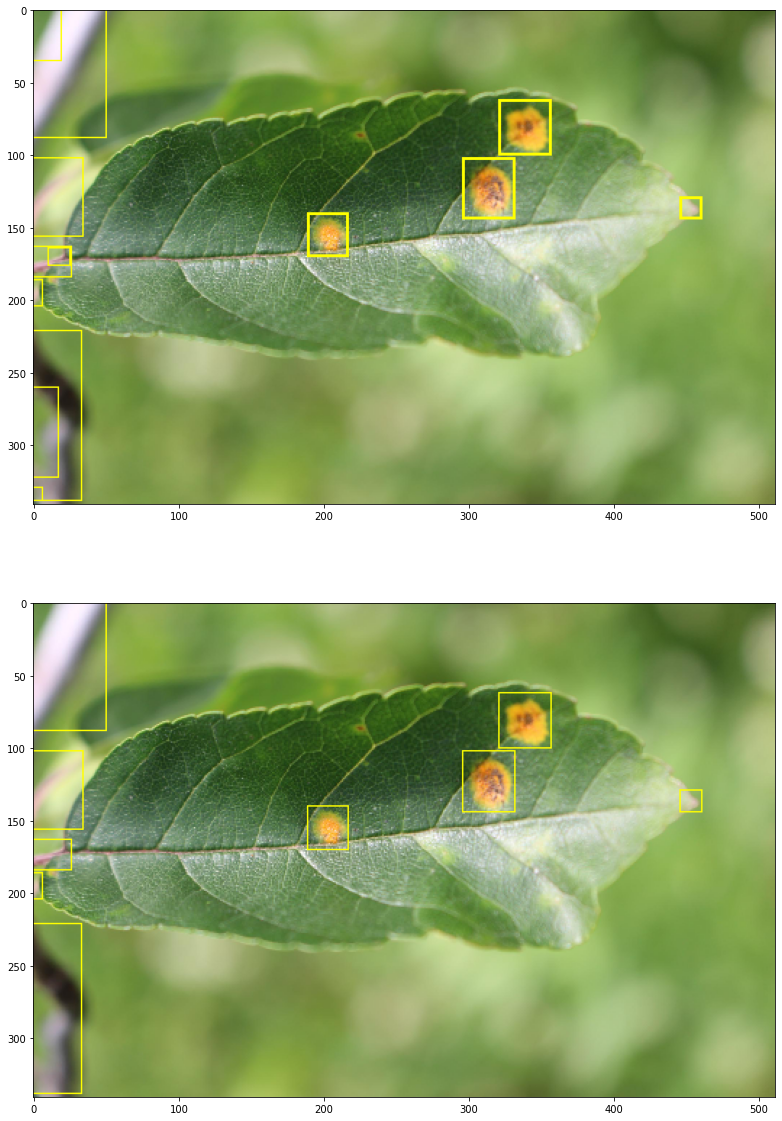

In [11]:
cases = images[labels.argmax(axis=1) == 2]

img = cases[0].copy()
img_ = img.copy()

boxes = get_boxes(img)
for xmin,ymin,xmax,ymax in boxes:
    img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,255,0),1)

    
boxes = suppress(boxes)    
for xmin,ymin,xmax,ymax in boxes:
    img_ = cv2.rectangle(img_,(xmin,ymin),(xmax,ymax),(255,255,0),1)
        
fig,axes = plt.subplots(2,1,figsize=(14,20))
axes[0].imshow(img)
axes[1].imshow(img_)

In [12]:
cases = images[labels.argmax(axis=1) == 3]